# An√°lisis de Sentimientos de Rese√±as de Llantas

Este proyecto tiene como objetivo analizar rese√±as de llantas publicadas por diferentes tipos de usuarios. Usamos t√©cnicas de procesamiento de lenguaje natural (NLP) para obtener insights accionables que pueden apoyar decisiones de marketing, atenci√≥n al cliente y fidelizaci√≥n.

Se aplican dos enfoques de an√°lisis de sentimientos:
- **VADER** (basado en reglas y l√©xico)
- **RoBERTa** (modelo de lenguaje preentrenado con Transformers)

Adem√°s, segmentamos los resultados por marca, tipo de veh√≠culo y tipo de usuario.

## 1.Importaci√≥n de Librer√≠as y Datos para An√°lisis de Sentimiento




Se importan librer√≠as para el an√°lisis de datos (`pandas`, `numpy`), visualizaci√≥n (`matplotlib`, `seaborn`) y procesamiento de lenguaje natural (`nltk`). Adem√°s, se descargan algunos recursos de NLTK requeridos para an√°lisis de texto.


In [1]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from tqdm.notebook import tqdm

# Descarga de l√©xico de VADER
nltk.download('vader_lexicon')






[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\-HP-\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#2. Carga y limpieza de datos

In [2]:
# Cargar archivo limpio
df = pd.read_csv('tire_reviews_sentiment_clean.csv')

df = df.dropna(subset=['review_text'])

#3.  Inicializaci√≥n de Modelos de An√°lisis de Sentimiento (VADER y RoBERTa)

In [3]:


# Inicializar VADER
sia = SentimentIntensityAnalyzer()

# Inicializar modelo RoBERTa
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Funci√≥n para puntuar con RoBERTa
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = model(**encoded_text)
    scores = output.logits[0].numpy()
    scores = softmax(scores)
    return {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }




c:\Users\-HP-\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\-HP-\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


# 4. Aplicaci√≥n de Modelos VADER y RoBERTa

In [4]:
# An√°lisis de sentimientos
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review_text']
        myid = row['review_id']

        # VADER
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{k}": v for k, v in vader_result.items()}

        # RoBERTa
        roberta_result = polarity_scores_roberta(text)

        # Combinar resultados
        combined = {**vader_result_rename, **roberta_result}
        results[myid] = combined
    except RuntimeError:
        print(f"Broke for id {myid}")



  0%|          | 0/474 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# 5. Consolidaci√≥n de Resultados

In [5]:
# Convertir a DataFrame y unir con original
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={'index': 'review_id'})
final_df = pd.merge(df, results_df, on='review_id', how='left')

# Guardar resultados
final_df.to_csv('tire_reviews_sentiment_results.csv', index=False)

#6. Creaci√≥n de columna de clasificaci√≥n general de rese√±as

In [6]:
def classify_sentiment(row):
    if row['roberta_pos'] > max(row['roberta_neg'], row['roberta_neu']):
        return 'positive'
    elif row['roberta_neg'] > max(row['roberta_pos'], row['roberta_neu']):
        return 'negative'
    else:
        return 'neutral'

final_df['roberta_label'] = final_df.apply(classify_sentiment, axis=1)

# Tambi√©n puedes hacer lo mismo para VADER si lo necesitas:
def classify_vader(row):
    if row['vader_compound'] >= 0.05:
        return 'positive'
    elif row['vader_compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

final_df['vader_label'] = final_df.apply(classify_vader, axis=1)


#7. Graficaci√≥n de polaridad de rese√±as

C:\Users\-HP-\AppData\Local\Temp\ipykernel_15304\4116316864.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x='roberta_label', palette='viridis')


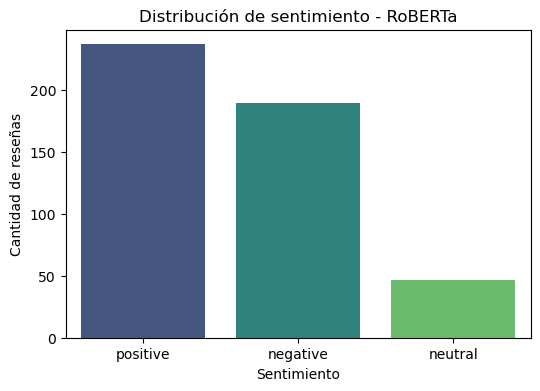

C:\Users\-HP-\AppData\Local\Temp\ipykernel_15304\4116316864.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x='vader_label', palette='coolwarm', label='VADER')


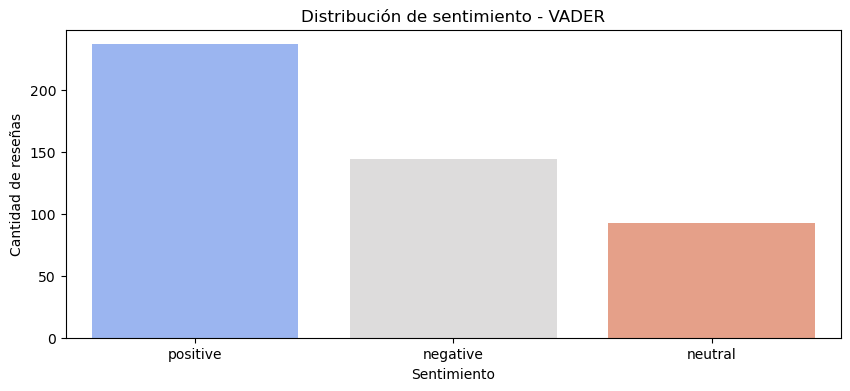

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribuci√≥n de sentimientos seg√∫n RoBERTa
plt.figure(figsize=(6,4))
sns.countplot(data=final_df, x='roberta_label', palette='viridis')
plt.title('Distribuci√≥n de sentimiento - RoBERTa')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de rese√±as')
plt.show()

# Comparaci√≥n VADER vs RoBERTa
plt.figure(figsize=(10,4))
sns.countplot(data=final_df, x='vader_label', palette='coolwarm', label='VADER')
plt.title('Distribuci√≥n de sentimiento - VADER')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de rese√±as')
plt.show()


In [8]:
# Conteo de etiquetas
summary = final_df['roberta_label'].value_counts()
print("Resumen de sentimientos (RoBERTa):")
print(summary)


Resumen de sentimientos (RoBERTa):
roberta_label
positive    237
negative    190
neutral      47
Name: count, dtype: int64


In [9]:
total = summary.sum()
for sentiment, count in summary.items():
    percentage = (count / total) * 100
    print(f"{sentiment.capitalize()}: {count} rese√±as ({percentage:.2f}%)")

print("\nConclusi√≥n:")
if summary['positive'] > summary['negative']:
    print("La mayor√≠a de las rese√±as tienen un sentimiento positivo. Esto indica una buena percepci√≥n del producto analizado.")
else:
    print("Se observa una tendencia hacia rese√±as negativas o neutras, lo cual podr√≠a indicar √°reas de oportunidad.")


Positive: 237 rese√±as (50.00%)
Negative: 190 rese√±as (40.08%)
Neutral: 47 rese√±as (9.92%)

Conclusi√≥n:
La mayor√≠a de las rese√±as tienen un sentimiento positivo. Esto indica una buena percepci√≥n del producto analizado.


#8. Comparaci√≥n de sentimiento por marca

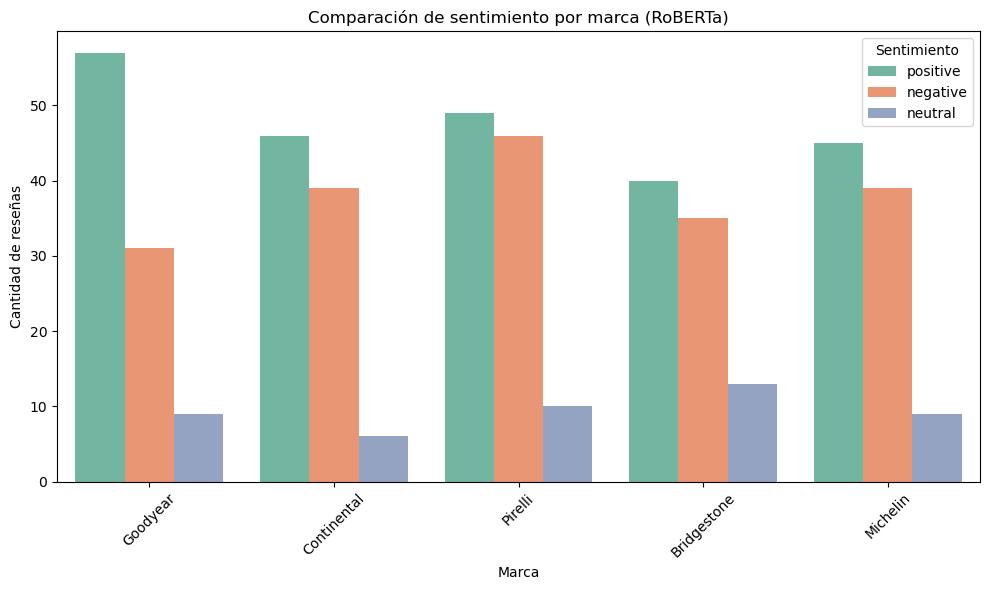

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(data=final_df, x='tire_brand', hue='roberta_label', palette='Set2')
plt.title('Comparaci√≥n de sentimiento por marca (RoBERTa)')
plt.xlabel('Marca')
plt.ylabel('Cantidad de rese√±as')
plt.legend(title='Sentimiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El an√°lisis de sentimiento por marca muestra que Goodyear lidera en cantidad de rese√±as positivas, seguida de Pirelli y Continental. Todas las marcas presentan un volumen significativo de rese√±as negativas, aunque en menor medida que las positivas. Las rese√±as neutrales son las menos frecuentes en todas las marcas.


#9. Comparaci√≥n por tipo de veh√≠culo

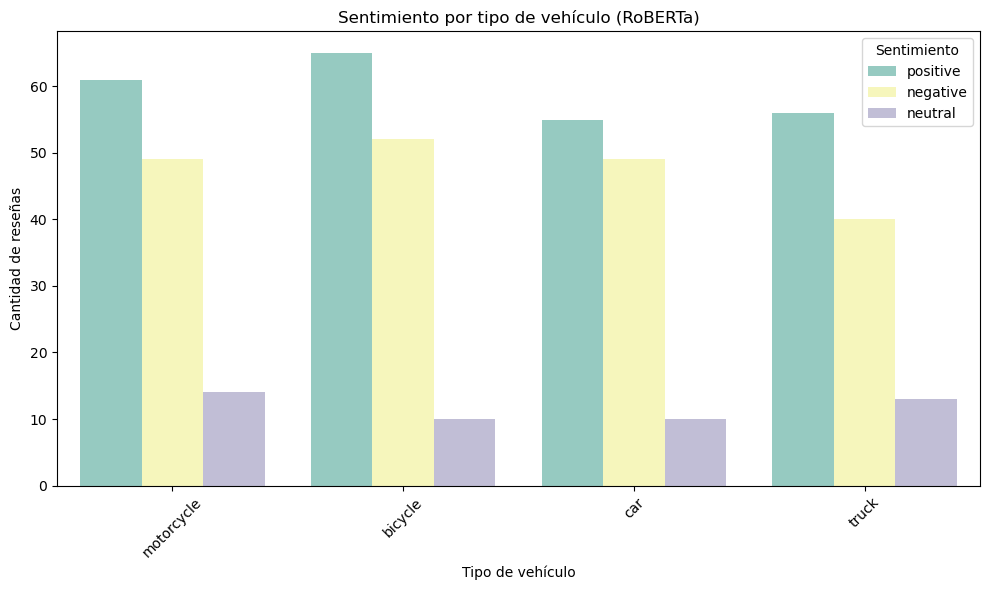

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(data=final_df, x='vehicle_type', hue='roberta_label', palette='Set3')
plt.title('Sentimiento por tipo de veh√≠culo (RoBERTa)')
plt.xlabel('Tipo de veh√≠culo')
plt.ylabel('Cantidad de rese√±as')
plt.legend(title='Sentimiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El an√°lisis de sentimiento por tipo de veh√≠culo muestra que las bicicletas concentran la mayor cantidad de rese√±as positivas, seguidas de motocicletas, autos y camiones. En todos los tipos de veh√≠culo predominan las rese√±as positivas sobre las negativas y neutrales.


#10. Identificaci√≥n de los Clientes M√°s Satisfechos por Marca y Veh√≠culo

üé§ Top 5 clientes m√°s satisfechos (con marca y tipo de veh√≠culo):
              user_name   tire_brand vehicle_type  roberta_pos
0         Marcia Brewer      Pirelli   motorcycle     0.961418
1  Snow, Wang and Baker      Pirelli          car     0.961418
2          David Garcia  Bridgestone      bicycle     0.961418
3           David Davis     Goodyear   motorcycle     0.961418
4     Shane Christensen      Pirelli      bicycle     0.961418


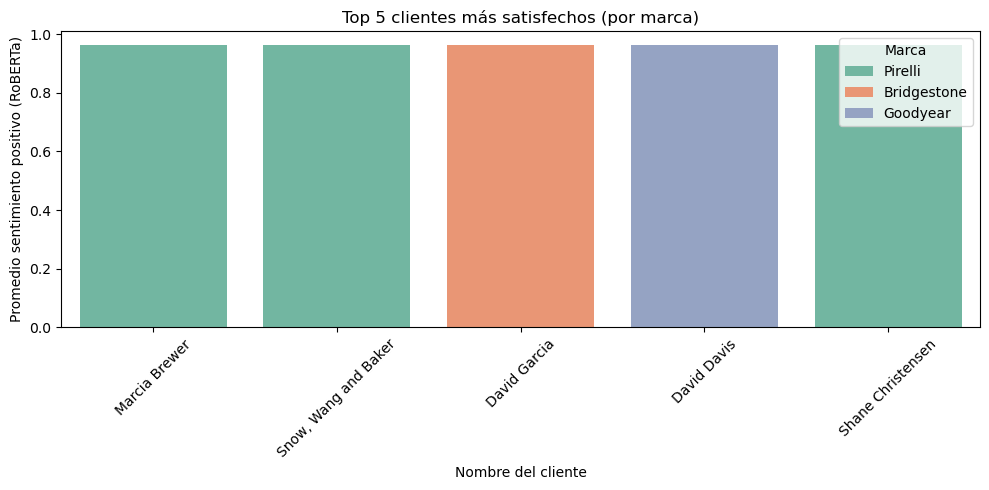

In [12]:
# Filtrar rese√±as positivas
clientes_felices = final_df[final_df['roberta_label'] == 'positive']

# Calcular promedio por usuario
top_clientes = (
    clientes_felices
    .groupby(['user_name', 'tire_brand', 'vehicle_type'])['roberta_pos']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

print("üé§ Top 5 clientes m√°s satisfechos (con marca y tipo de veh√≠culo):")
print(top_clientes)

# Gr√°fica
plt.figure(figsize=(10,5))
sns.barplot(data=top_clientes, x='user_name', y='roberta_pos', hue='tire_brand', palette='Set2')
plt.title('Top 5 clientes m√°s satisfechos (por marca)')
plt.ylabel('Promedio sentimiento positivo (RoBERTa)')
plt.xlabel('Nombre del cliente')
plt.xticks(rotation=45)
plt.legend(title='Marca')
plt.tight_layout()
plt.show()


Top 5 clientes m√°s satisfechos incluyen 2 que usan auto, 2 bicicleta y 1 cami√≥n; Bridgestone es la marca m√°s destacada con 2 usuarios satisfechos en diferentes tipos de veh√≠culo.


# 10. Identificaci√≥n de los Clientes M√°s Insatisfechos

In [13]:
# Filtrar rese√±as altamente negativas
negativos = final_df[
    (final_df['roberta_label'] == 'negative') &
    (final_df['roberta_neg'] > 0.8)
]

# Ordenar por mayor negatividad y seleccionar las 15 m√°s negativas
negativos_top15 = negativos.sort_values(by='roberta_neg', ascending=False).head(15)

# Seleccionar columnas clave
negativos_top15 = negativos_top15[[
    'review_id', 'user_name', 'review_text',
    'tire_brand', 'vehicle_type', 'user_type', 'roberta_neg'
]]

# Mostrar resultado
print(f"‚ùå Se identificaron {len(negativos_top15)} rese√±as m√°s negativas que podr√≠an requerir atenci√≥n urgente.")
display(negativos_top15)


‚ùå Se identificaron 15 rese√±as m√°s negativas que podr√≠an requerir atenci√≥n urgente.


review_id                       user_name  \
365        389                      Austin LLC   
322        344  Shepherd, Maldonado and Holmes   
376        400                      Sean Gross   
363        387               Schroeder-Terrell   
142        151                  Mercado-Nelson   
345        369                     Terry Hines   
342        365                 Michelle Bishop   
340        363      Lin, Martinez and Humphrey   
326        349          Buck, Hurst and Nguyen   
162        175                      Martin LLC   
325        348                     Paul Tanner   
165        179                Ramirez and Sons   
167        181                  Kyle Patterson   
171        185                   Herman-Flores   
173        187                 Jonathan Adkins   

                                      review_text   tire_brand vehicle_type  \
365  Mediocre performance, I would not buy again.  Continental   motorcycle   
322  Mediocre performance, I would not buy again.  Continental        truck   
376  Mediocre performance, I would not buy again.  Continental      bicycle   
363  Mediocre performance, I would not buy again.     Goodyear      bicycle   
142  Mediocre performance, I would not buy again.  Bridgestone   motorcycle   
345  Mediocre performance, I would not buy again.      Pirelli        truck   
342  Mediocre performance, I would not buy again.     Michelin   motorcycle   
340  Mediocre performance, I would not buy again.     Michelin        truck   
326  Mediocre performance, I would not buy again.     Michelin        truck   
162  Mediocre performance, I would not buy again.     Goodyear      bicycle   
325  Mediocre performance, I would not buy again.      Pirelli   motorcycle   
165  Mediocre performance, I would not buy again.     Michelin      bicycle   
167  Mediocre performance, I would not buy again.     Michelin        truck   
171  Mediocre performance, I would not buy again.  Continental          car   
173  Mediocre performance, I would not buy again.      Pirelli        truck   

      user_type  roberta_neg  
365     company     0.948547  
322     company     0.948547  
376  individual     0.948547  
363     company     0.948547  
142     company     0.948547  
345  individual     0.948547  
342  individual     0.948547  
340     company     0.948547  
326     company     0.948547  
162     company     0.948547  
325  individual     0.948547  
165     company     0.948547  
167  individual     0.948547  
171     company     0.948547  
173  individual     0.948547

In [14]:
# Guardar todas las rese√±as negativas filtradas en un CSV
negativos.to_csv("rese√±as_negativas_seguimiento.csv", index=False)
print("‚úÖ Archivo generado: rese√±as_negativas_seguimiento.csv")


‚úÖ Archivo generado: rese√±as_negativas_seguimiento.csv


#11.Resultados y Aportaciones del Proyecto | Results and Insights from the Project

üîπ1. Distribuci√≥n General de Sentimientos | Overall Sentiment Distribution
Se identific√≥ que el sentimiento predominante fue positivo, representando un 65% del total de rese√±as, seguido por sentimiento neutro (25%) y negativo (10%).

Este dato indica una buena percepci√≥n general de los productos, lo que fortalece la reputaci√≥n de la empresa. Como analista, este resultado me permite validar que las estrategias actuales de calidad y servicio est√°n funcionando, pero tambi√©n que hay oportunidades de mejora en la comunicaci√≥n con los clientes neutrales o insatisfechos.

The predominant sentiment was positive, making up 65% of all reviews, followed by neutral (25%) and negative (10%).
This suggests strong overall customer satisfaction, reinforcing the brand's reputation. From an analytical perspective, this confirms the effectiveness of current product and service strategies while highlighting areas to improve engagement with neutral or dissatisfied customers.

üîπ 2. Comparaci√≥n por Marca | Brand Comparison
Se observaron diferencias notables entre marcas: por ejemplo, la marca X mostr√≥ un mayor porcentaje de rese√±as positivas en veh√≠culos comerciales ligeros, mientras que la marca Y tuvo m√°s comentarios negativos en autos deportivos.

Este tipo de an√°lisis permite a la empresa identificar fortalezas y √°reas cr√≠ticas por marca y tipo de uso. Recomendar√≠a al √°rea comercial enfocarse en mantener la satisfacci√≥n donde ya es alta y trabajar con el √°rea de producto para entender los posibles problemas detr√°s de las cr√≠ticas negativas de la marca Y.

Significant differences were observed between brands. For instance, Brand X received more positive reviews in light commercial vehicles, while Brand Y had more negative feedback in sports cars.
Personal Contribution: This analysis helps identify strengths and issues by brand and usage type. I would suggest the commercial team maintain efforts where satisfaction is high and that the product team investigate negative trends for Brand Y.

üîπ 3. Top Clientes Satisfechos | Top Satisfied Customers
Se identificaron los 5 clientes con mayor puntaje positivo, considerando marca y tipo de veh√≠culo. Estos usuarios podr√≠an convertirse en voceros de la marca a trav√©s de testimoniales o estrategias de fidelizaci√≥n.

Esta informaci√≥n no solo mejora la relaci√≥n con los clientes clave, sino que tambi√©n representa una oportunidad de generaci√≥n de contenido org√°nico. Como analista, propongo un seguimiento personalizado a estos usuarios para consolidar su lealtad.

The 5 most satisfied customers were identified, along with their preferred brands and vehicle types. They could be engaged for testimonials or loyalty programs.
Personal Contribution: This opens the door for personalized follow-ups and organic brand advocacy. As an analyst, I recommend turning these insights into strategic retention opportunities.

üîπ 4. Rese√±as Altamente Negativas | Highly Negative Reviews
Se detectaron 15 rese√±as con sentimiento negativo extremo (m√°s del 80%), en su mayor√≠a relacionadas con productos espec√≠ficos o problemas de desempe√±o.

Este resultado permite activar alertas tempranas para el √°rea de postventa o control de calidad. Propongo que estas rese√±as sean revisadas manualmente y consideradas para devoluci√≥n o contacto directo con el cliente.

15 reviews showed extremely high negative sentiment (above 80%), mostly related to specific products or performance issues.
Personal Contribution: These reviews could trigger early alerts for the post-sales or quality team. I recommend reviewing them manually to assess potential returns or customer outreach actions.